
Expected :
MNST    0.0011
AAPL   -0.0000
ODFL    0.0028
AMZN    0.0035
ISRG   -0.0006
TSCO    0.0035
TYL     0.0011
IDXX    0.0011
BKNG   -0.0005
HUM     0.0012
ORLY    0.0005
CNC     0.0016
ROL     0.0010
WST     0.0006
ALGN    0.0028
ANSS    0.0008
CTSH    0.0027
CMI     0.0005
JBHT    0.0018
ILMN   -0.0013
SHW     0.0005
UNH     0.0008
AZO     0.0007
POOL    0.0015
CSGP    0.0011
ROST    0.0009
AME     0.0009
EW      0.0001
ON      0.0014
NVDA   -0.0029
ALB     0.0003
HOLX    0.0007
DE      0.0008
IT      0.0002
APH     0.0004
GILD    0.0012
MTD    -0.0006
AMT     0.0003
AOS     0.0012
REGN   -0.0015
BLK     0.0005
STZ     0.0008
SBUX    0.0010
ELV     0.0007
DHR     0.0007
TDY     0.0000
VLO     0.0003
ATVI   -0.0003
TMO    -0.0001
CHD     0.0008
dtype: float64
0 : error=0.0282


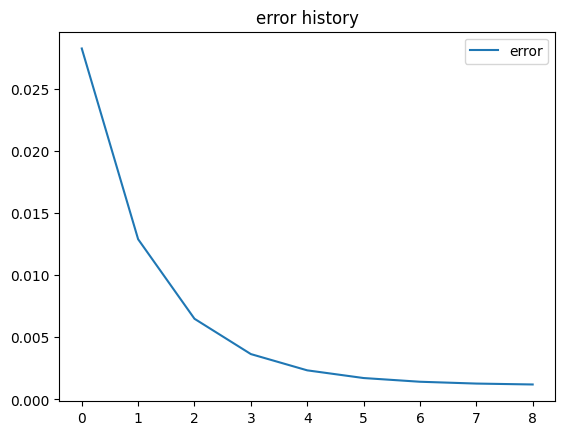


R :
[[ 0.02  0.01 -0.03 ... -0.    0.02 -0.  ]
 [ 0.02  0.   -0.   ...  0.02  0.   -0.01]
 [-0.   -0.03  0.02 ... -0.03  0.01 -0.02]
 ...
 [-0.01 -0.    0.03 ...  0.02 -0.01  0.  ]
 [-0.   -0.03 -0.03 ...  0.05 -0.    0.  ]
 [ 0.03 -0.01 -0.02 ...  0.02  0.03  0.06]]

Estimated R :
[[ 0.01 -0.   -0.01 ... -0.01 -0.01 -0.03]
 [ 0.   -0.01 -0.   ...  0.    0.    0.01]
 [-0.01 -0.   -0.02 ... -0.02 -0.01 -0.01]
 ...
 [ 0.01  0.    0.   ...  0.02  0.   -0.01]
 [ 0.   -0.   -0.02 ...  0.   -0.   -0.  ]
 [ 0.01 -0.01  0.02 ...  0.02  0.    0.  ]]

F :
[[-0.15 -0.13  0.22 ...  0.36  0.3   0.11]
 [ 0.32  0.42  0.27 ... -0.08 -0.06 -0.22]
 [ 0.15 -0.02  0.07 ...  0.49  0.17  0.2 ]
 ...
 [ 0.28  0.85  0.24 ...  0.12  0.72  0.79]
 [ 0.87  0.62  0.64 ...  0.26  0.79  0.59]
 [ 0.11  0.8   0.57 ...  0.58  0.82  0.09]]

B :
[[-0.   -0.01 -0.01  0.02 -0.01 -0.01  0.   -0.01  0.    0.    0.   -0.02
  -0.01 -0.01 -0.02  0.02  0.02  0.02  0.   -0.02 -0.02 -0.01  0.01 -0.01
   0.01  0.   -0.   -0.01  0. 

In [31]:
# 행렬 분해 : R = F * B
# NaN이 포함된 R이 주어졌을 때 행렬 F, B를 추정한다. (by Stochastic Gradient Descent)
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("top50-Stock_LogReturn.csv", index_col="Date")[:462]
E = df.mean(axis=0)
X = df - E

# User-item matrix
N = np.NaN
R = np.array(X)

print('\nExpected :')
print(E.round(4))

N_ROW = R.shape[0]
N_COL = R.shape[1]

@nb.jit
# SGD로 행렬 F, B를 업데이트한다.
def update_matrix(R, F, B, a, r):
    for i in range(N_ROW):
        for j in range(N_COL):
            if np.isnan(R[i, j]) != True:  # nan이 아니면
                # error 항을 계산한다.
                eij = R[i, j] - np.dot(F[i, :], B[j, :])
                
                # update F, B
                F[i, :] += a * (eij * B[j, :] - r * F[i, :])
                B[j, :] += a * (eij * F[i, :] - r * B[j, :])

@nb.jit
# NaN이 포함된 행렬의 mean_squared_error를 계산한다. 행렬 x에는 NaN이 포함돼 있다. y에는 없다.
def mse_skip_nan(x, y):
    mse = 0.0
    cnt = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i, j]) != True:  # nan이 아니면
                mse += (x[i, j] - y[i, j]) ** 2
                cnt += 1
    return mse / cnt

# SGD로 행렬을 F, B로 분해한다.
def factorize_matrix(matR, k, max_iter=1000, alpha=0.01, gamma=0.01, err_limit=1e-4):
    # F, B를 random 초기화한다.
    F = np.random.rand(N_ROW, k)  # factor matrix
    B = np.random.rand(N_COL, k)  # beta matrix.

    old_err = 9999   # error 초깃값
    err_hist = []    # error history
    for step in range(max_iter):
        # F, B를 업데이트한다.
        update_matrix(matR, F, B, alpha, gamma)

        # error를 계산하고 저장해 둔다.
        err = mse_skip_nan(matR, np.dot(F, B.T))
        err_hist.append(err)

        # early stopping
        if np.abs(old_err - err) < err_limit:
            break
        
        old_err = err

        if step % 10 == 0:
            print('{} : error={:.4f}'.format(step, err))

    if step >= max_iter - 1:
        print('max_iter={}번 동안 stop하지 못했습니다.'.format(max_iter))
        print('max_iter를 늘리거나 err_limit을 늘려야 합니다.')

    return F, B.T, err_hist

K = 10               # number of factors
F, B, err = factorize_matrix(R, K)
ER = np.dot(F, B)   # estimated R

# error history를 관찰한다.
plt.plot(err, label='error')
plt.legend()
plt.title('error history')
plt.show()

print('\nR :')
print(np.round(R, 2))
print('\nEstimated R :')
print(np.round(ER, 2))   
print('\nF :')
print(np.round(F, 2))
print('\nB :')
print(np.round(B, 2))

In [32]:
print(X.iloc[:5, :5].round(3), X.shape, end="\n\n")
print(F.round(3), F.shape, end="\n\n")
print(B[:, :4].round(3), B.shape)

             MNST   AAPL   ODFL   AMZN   ISRG
Date                                         
2002-01-03  0.023  0.012 -0.033  0.079 -0.057
2002-01-04  0.022  0.005 -0.003  0.026 -0.016
2002-01-07 -0.001 -0.034  0.022  0.004 -0.019
2002-01-08  0.017 -0.013  0.029 -0.044  0.015
2002-01-09 -0.027 -0.043 -0.003 -0.031  0.001 (462, 50)

[[-0.152 -0.13   0.221 ...  0.365  0.295  0.111]
 [ 0.319  0.42   0.27  ... -0.083 -0.06  -0.22 ]
 [ 0.149 -0.021  0.075 ...  0.486  0.168  0.2  ]
 ...
 [ 0.283  0.848  0.244 ...  0.117  0.718  0.788]
 [ 0.867  0.62   0.643 ...  0.259  0.791  0.59 ]
 [ 0.113  0.8    0.57  ...  0.583  0.822  0.091]] (462, 10)

[[-0.003 -0.015 -0.01   0.018]
 [-0.001 -0.005 -0.003 -0.005]
 [ 0.004  0.025  0.028  0.012]
 [ 0.014 -0.016 -0.002 -0.006]
 [-0.005  0.009 -0.027 -0.025]
 [-0.     0.016  0.025  0.01 ]
 [-0.005 -0.002 -0.016 -0.004]
 [-0.018 -0.012 -0.012 -0.001]
 [ 0.011 -0.01   0.013  0.016]
 [ 0.008  0.016  0.004 -0.011]] (10, 50)


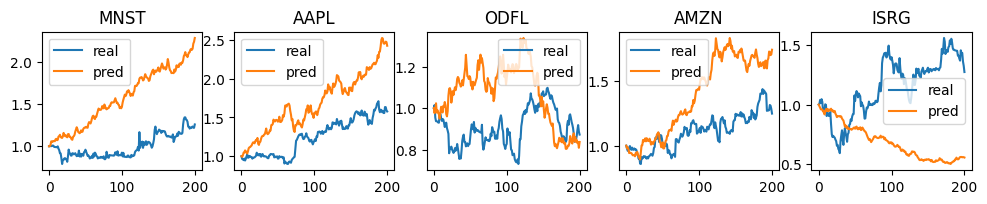

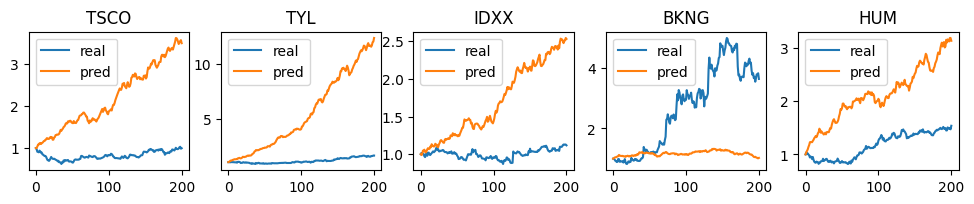

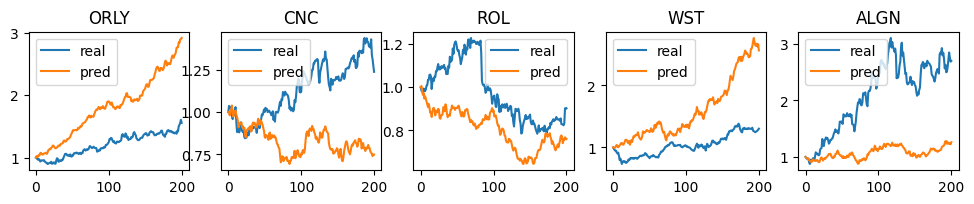

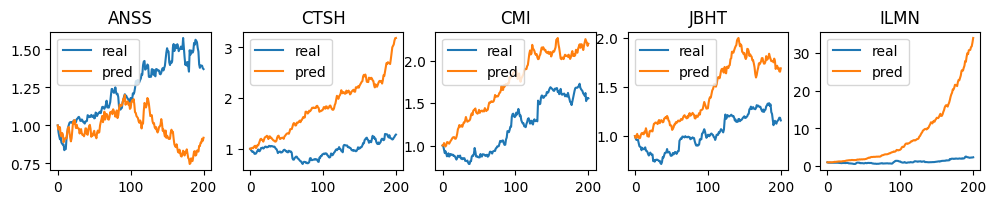

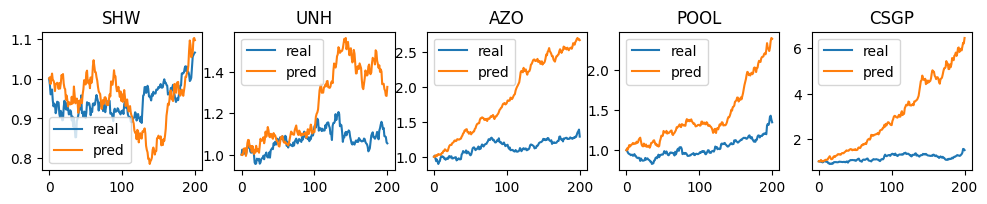

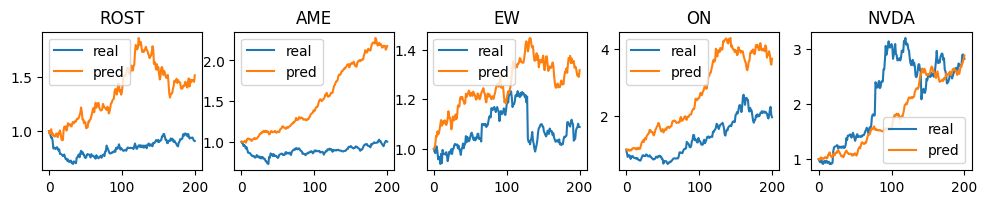

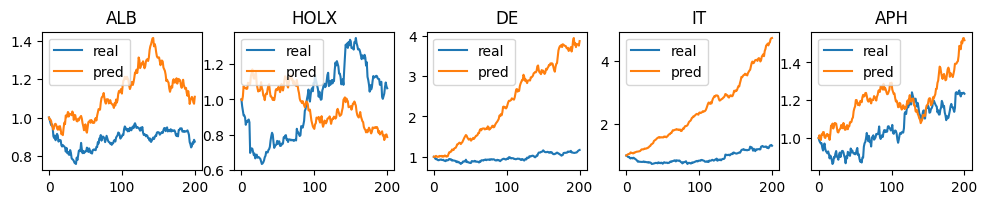

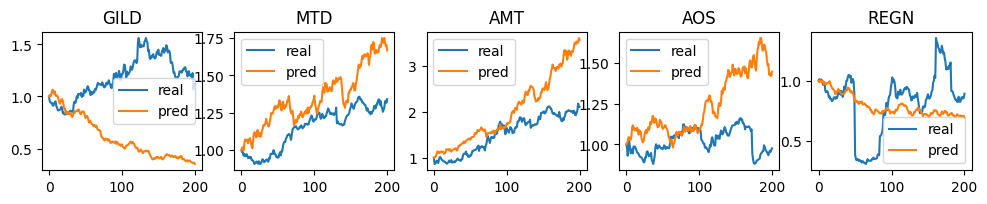

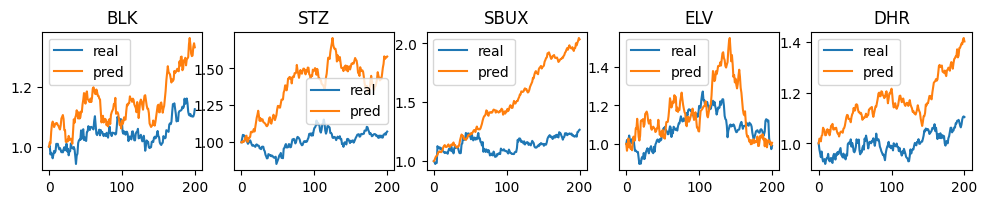

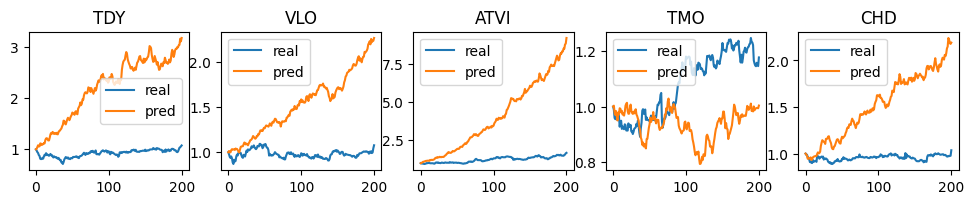

In [49]:
# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = ER + np.dot(F, B)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

# 10행 5열의 plot chart를 그린다.
n_from = -200   # 최근 200 weeks (약 4년)의 주가 차트
for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        # 추정 주가와 실제 주가를 계산한다.
        pred_price = calc_price(rtn_EFB[:, j][n_from:])
        real_price = calc_price(R[:, j][n_from:])
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.plot(real_price, label='real')
        ax.plot(pred_price, label='pred')
        ax.legend()
        ax.set_title(idx2sym[j])
    plt.show() 

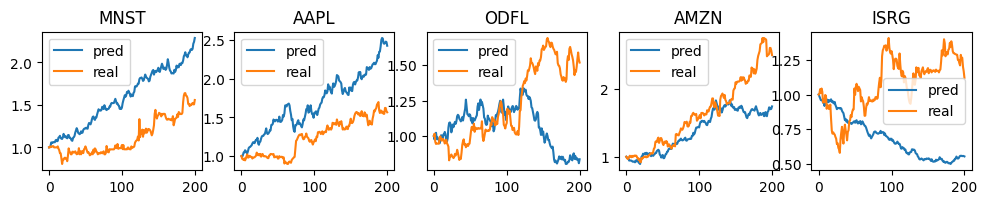

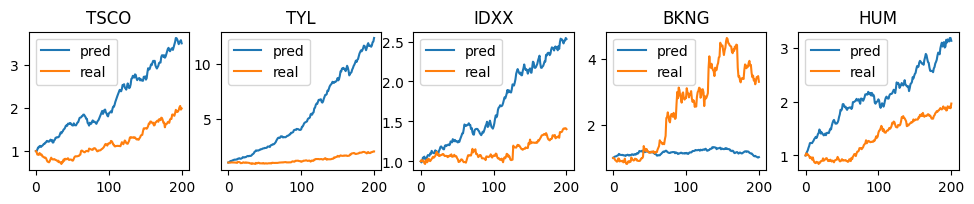

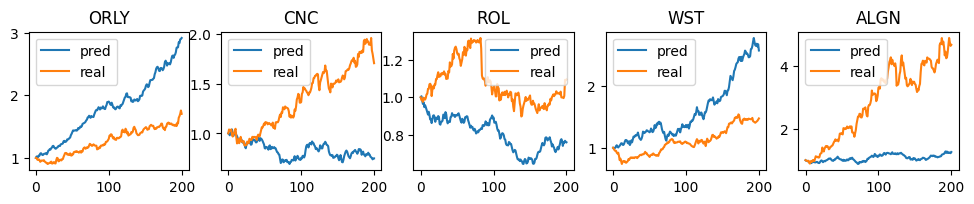

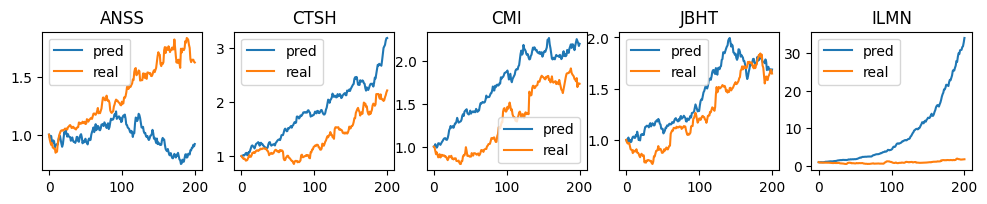

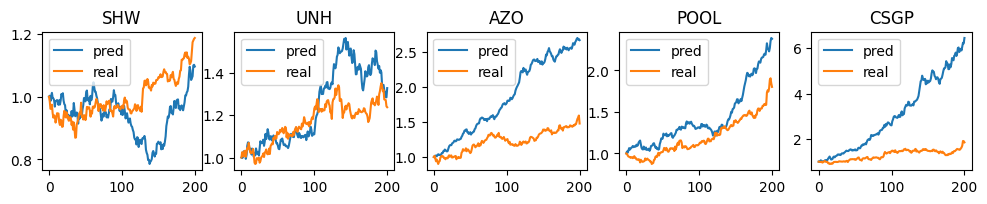

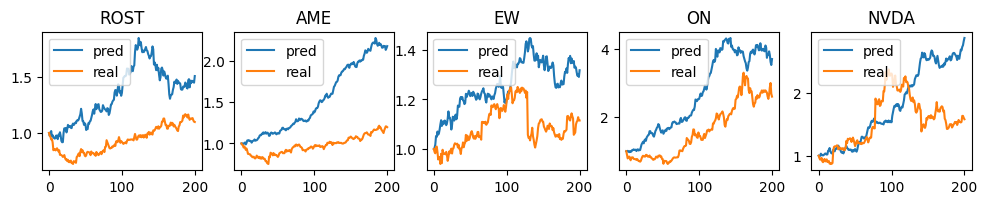

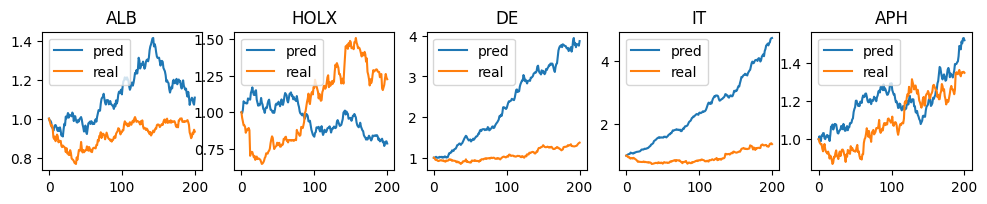

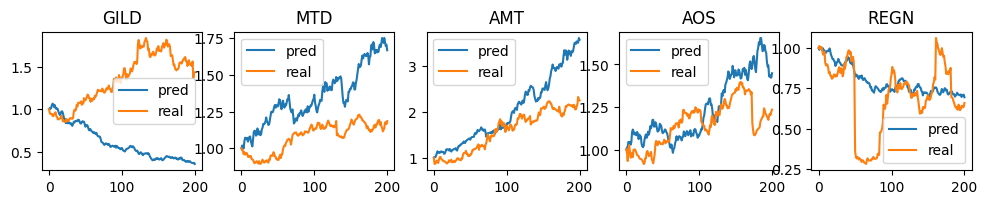

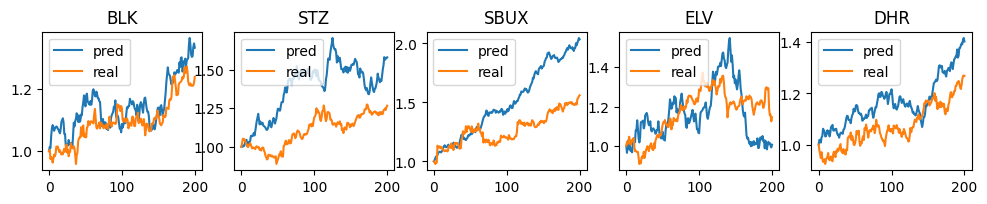

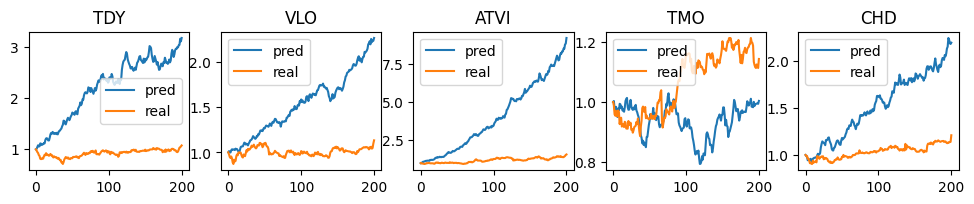

In [55]:
dfn = df.to_numpy()
for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        # 추정 주가와 실제 주가를 계산한다.
        pred_price = calc_price(rtn_EFB[:, j][n_from:])
        real_price = calc_price(dfn[:, j][n_from:])
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.plot(pred_price, label='pred')
        ax.plot(real_price, label='real')
        ax.legend()
        ax.set_title(idx2sym[j])
    plt.show() 